# Scalar Grad Dev and Demo

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, math
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

## Functions

In [2]:
def trace(root):
  """
  Builds a set of all nodes and edges in a graph
  """
  nodes,edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes,edges

# def draw_dot(root, format='svg', rankdir='LR'):
#   """
#   format: png | svg | ...
#   rankdir: TB (top to bottom graph) | LR (left to right)
#   """
#   assert rankdir in ['LR', 'TB']
#   nodes,edges = trace(root)
#   dot = Digraph(format=format, graph_attr={'rankdir': rankdir, 'ordering': 'in'}, engine='dot')
  
#   for n in nodes:
#     if hasattr(n, 'grad') and n.grad != 0:
#       dot.node(name=str(id(n)), label = '{%s|%.3f}|{do/d%s|%.3f}' % (n.label,n.data,n.label,n.grad), shape='record')
#     else:
#       dot.node(name=str(id(n)), label = '{%s|%.3f}' % (n.label,n.data), shape='record')      
#     if n.op:
#       dot.node(name=f'{str(id(n))}{n.op}', label=n.op)
#       dot.edge(f'{str(id(n))}{n.op}', str(id(n)))
      
#   for n1,n2 in edges:
#     dot.edge(str(id(n1)), f'{str(id(n2))}{n2.op}')

#   if hasattr(n, 'grad'):
#     for n1, n2 in edges:
#       if n2.grad != 0:
#         dot.edge(str(id(n1)), f'{str(id(n2))}', color='red', style='dashed', dir='back')

#   return dot

def draw_dot(root, format='svg', rankdir='LR', show_backprop=True):
  """
  format: png | svg | ...
  rankdir: TB (top to bottom graph) | LR (left to right)
  """
  assert rankdir in ['LR', 'TB']
  nodes,edges = trace(root)
  dot = Digraph(format=format, graph_attr={'rankdir': rankdir, 'ordering': 'in'}, engine='dot')
  
  for n in nodes:
    if hasattr(n, 'grad_updated') and n.grad_updated:
      deri = f'({n.label})' if len(n.label) > 2 else n.label
      dot.node(name=str(id(n)), label = '{%s|%.3f}|{do/d%s|%.3f}' % (n.label,n.data,deri,n.grad), shape='record')
    else:
      dot.node(name=str(id(n)), label = '{%s|%.3f}' % (n.label,n.data), shape='record')
    
    if n.op:
      dot.node(name=f'{str(id(n))}{n.op}', label=n.op)
      dot.edge(f'{str(id(n))}{n.op}', str(id(n)))
      
  for n1,n2 in edges:
    dot.edge(str(id(n1)), f'{str(id(n2))}{n2.op}')
  
  if show_backprop:
    if hasattr(n, 'grad_updated'):
      for n1, n2 in edges:
        if n2.grad != 0:
          dot.edge(str(id(n1)), f'{str(id(n2))}', color='red', style='dashed', dir='back')       
  
  return dot

## What is a derivative?

1. Define `f(x)` and show some values. Its a quadric equation so its a parabola.
2. Plot it with `xs = np.arange(-5, 5, 0.25)` and get `ys` with `f(xs)`
3. What is the derivative at each point? Solving with calculus with formulas...but
4. we are doing it using first principles

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
xs  = np.arange(-5, 5, 0.25)
ys = f(xs)

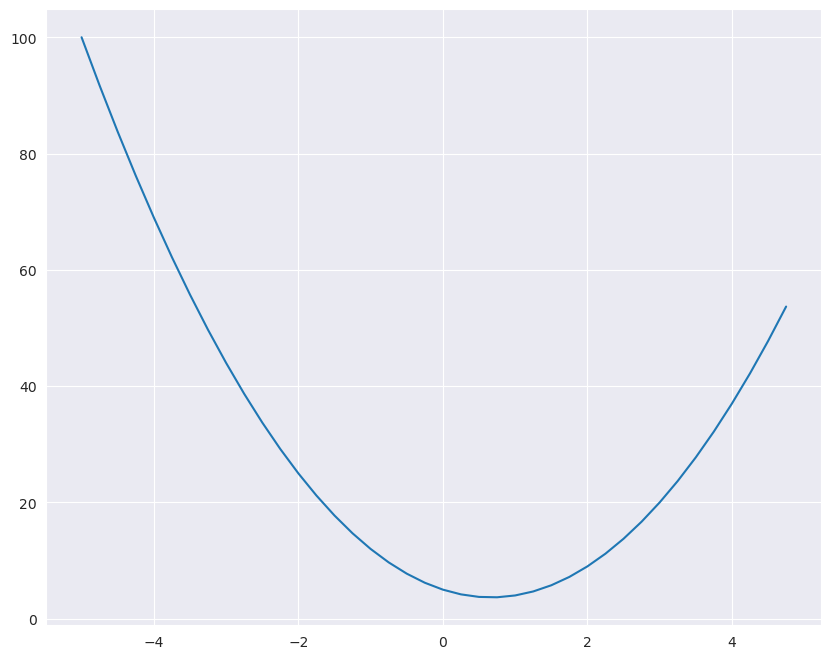

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.plot(xs, ys)

In [6]:
h = 0.000001

In [7]:
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [8]:
x = -3.0
(f(x + h) - f(x)) / h

-21.999997002808414

In [9]:
x = -3.0
(f(x + h) - f(x)) / h

-21.999997002808414

In [10]:
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

## Partial derivatives with multiple variables

1. Define a simple expression with 3 variables `d = a*b + c` and get the partial derivatives
2. We will go into NN's net

In [11]:
h = 0.000001

In [12]:
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

c += h
d2 = a*b + c

print(f'{d1 = }')
print(f'{d2 = }')
print(f'{(d2-d1)/h = }')

d1 = 4.0
d2 = 4.000000999999999
(d2-d1)/h = 0.9999999992515995


## Class Dev - Manual Backprop

### Forward Pass

1. Barebones `Scalar` class with just data
2. Add the dunder methods for arithmetics
3. We want to keep *expression graphs*, so we need to know and keep pointers of what `Scalar` produce other `Scalar`
4. Add `_children` tuple and modify dunder methods
5. What operation created the `Scalar`? Add `_op` attribute
6. Give the scalar a name
7. Draw computational graph
8. More complex expression with more variables

In [13]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label='unk'):
    self.data = data
    self.prev = set(children)
    self.op = op
    self.label = label
    
  def __add__(self, other):
    return Scalar(self.data + other.data, (self, other), '+')
  
  def __mul__(self, other):
    return Scalar(self.data * other.data, (self, other), '*')
  
  def __repr__(self):
    return f"{self.label}|{self.data}"

In [14]:
a = Scalar(2.0, label='a')
b = Scalar(-3.0, label='b')
c = Scalar(10.0, label='c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Scalar(-2.0, label='f')
o = e*f; o.label = 'o'
o

o|-8.0

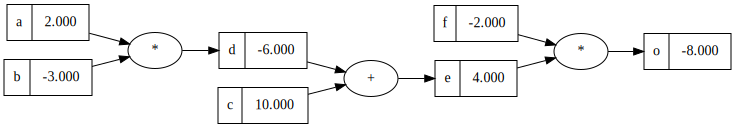

In [15]:
draw_dot(o)

### Backward Pass
1. We are going to backpropagate through the graph by computing the derivative of that node w.r.t. to output L
2. Derivative of L w.r.t. L is just 1
3. In NN setting, L would be the loss function and everything except a and b are the parameters (weights)
4. How the weights impact the loss function?
5. Since the data is fixed, we don't necessarily care about the derivative of the loss w.r.t. data (exception adversarial ML where we want to manipulate the data to impact the loss ie fgsm)

1. Maintain the gradient variable
2. Numerical gradient in foo function
3. l,e,f backprop
4. Most important gradient: understanding this => understanding all of backprop
5. Calculate the *local* derivative
6. CHAIN RULE for global derivative

In [16]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """  
  def __init__(self, data, children=(), op='', label='unk'):
    self.data = data
    self._grad = 0.0
    self.grad_updated = False
    self.prev = set(children)
    self.op = op
    self.label = label

  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    return Scalar(self.data + other.data, (self, other), '+')
  
  def __mul__(self, other):
    return Scalar(self.data * other.data, (self, other), '*')
  
  def __repr__(self):
    return f'{self.label}|{self.data:0.3f}|{self._grad:0.3f}'

In [26]:
a = Scalar(2.0, label='a')
b = Scalar(-3.0, label='b')
c = Scalar(10.0, label='c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Scalar(-2.0, label='f')
o = e*f; o.label = 'o'
o

o|-8.000|0.000

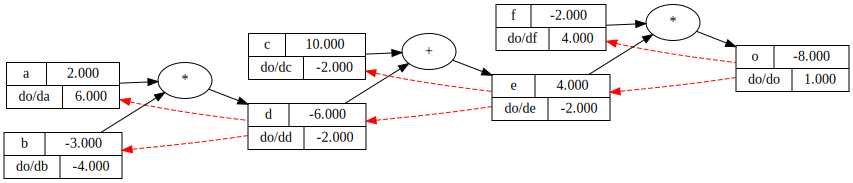

In [37]:
draw_dot(o)

`+` just *routes* the gradient

In [29]:
o.grad = 1.0

In [31]:
e.grad = f.data
f.grad = e.data

In [33]:
c.grad = e.grad * 1.0
d.grad = e.grad * 1.0

In [35]:
a.grad = (-2.0) * -3.0
b.grad = (-2.0) * 2

Lets nudge the leaf nodes (that we have influence over) and re-run the forward pass (over ops we don't have influence over) and print out the loss

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
o = e*f; o.label = 'o'
o

In [ ]:
def foo():
  h = 0.000001
  
  a = Scalar(2.0, label='a')
  b = Scalar(-3.0, label='b')
  c = Scalar(10.0, label='c')
  d = a*b; d.label = 'd'
  e = d+c; e.label = 'e'
  f = Scalar(-2.0, label='f')
  o = e*f; o.label = 'o'
  o1 = o.data
  
  a = Scalar(2.0, label='a')
  b = Scalar(-3.0, label='b')
  b.data+=h
  c = Scalar(10.0, label='c')
  d = a*b; d.label = 'd'
  e = d+c; e.label = 'e'
  f = Scalar(-2.0, label='f')
  o = e*f; o.label = 'o'
  o2 = o.data
  
  print((o2-o1)/h)

foo()

### Manual Backprop with a neuron

1. Neurons have inputs `x` and weights `w`
2. `w*x` is the input to the neuron with a bias which will be adjusted to either fire the neuron or not
3. Activation function to squash the inputs to some range, we are using `tanh`
4. Activation function takes in the dot products of its inputs

In [38]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """  
  def __init__(self, data, children=(), op='', label='unk'):
    self.data = data
    self._grad = 0.0
    self.prev = set(children)
    self.grad_updated = False
    self.op = op
    self.label = label
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    return Scalar(self.data + other.data, (self, other), '+')
  
  def __mul__(self, other):
    return Scalar(self.data * other.data, (self, other), '*')
  
  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    return Scalar(t, (self, ), 'tanh') 
  
  def __repr__(self):
    return f'{self.label}|{self.data:0.3f}|{self.grad:0.3f}'

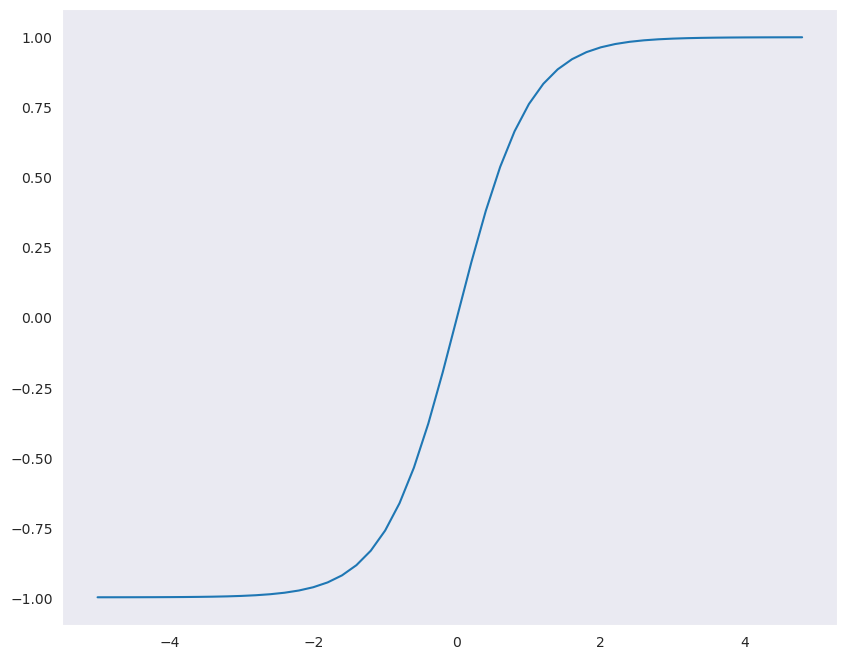

In [39]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
ax.grid()

Change bias to `6.8813735870195432` for backprop

In [40]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

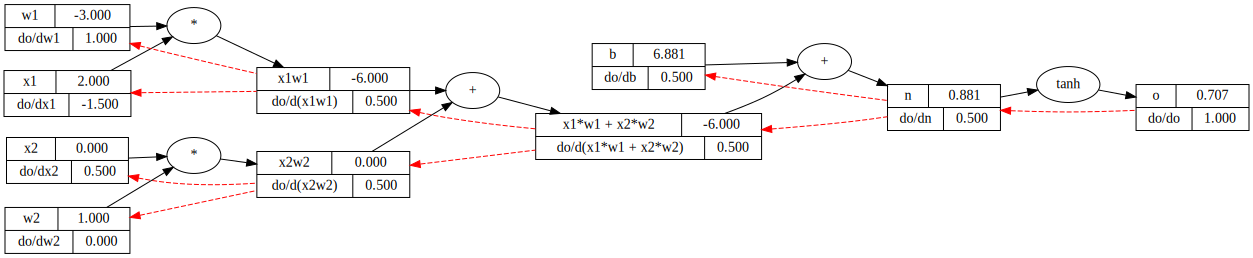

In [47]:
draw_dot(o)

1. Derivative of `tanh` is `1-tanh^2`
2. `x2` has no influence on output since gradient is zero

In [42]:
o.grad = 1.0

In [43]:
n.grad = 1 - o.data**2

In [44]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [45]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [46]:
x2.grad = w2.data * x2w2.grad
w2.grad = (x2.data * x2w2.grad)

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

### Automatic backprop

1. Backward func by default doesn't do anything and will do the little piece of chain rule. Leaf code has nothing to do

In [48]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """  
  def __init__(self, data, children=(), op='', label='unk'):
    self.data = data
    self._grad = 0.0
    self._backward = lambda: None
    self.prev = set(children)
    self.grad_updated = False
    self.op = op
    self.label = label
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    out = Scalar(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad   
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Scalar(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Scalar(t, (self, ), 'tanh') 
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def __repr__(self):
    return f'{self.label}|{self.data:0.3f}|{self.grad:0.3f}'

In [49]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = '(x1*w1 + x2*w2)'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

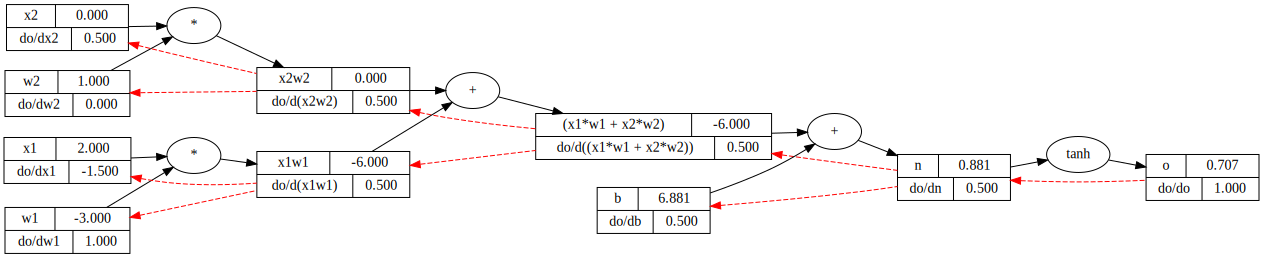

In [56]:
draw_dot(o)

In [51]:
o.grad = 1.0
o._backward()

In [52]:
n._backward()

In [53]:
b._backward()

In [54]:
x1w1x2w2._backward()

In [55]:
x1w1._backward()
x2w2._backward()

### Automatic backprop with one function call with Topo sort

In [57]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """  
  def __init__(self, data, children=(), op='', label='unk'):
    self.data = data
    self._grad = 0.0
    self._backward = lambda: None
    self.prev = set(children)
    self.grad_updated = False
    self.op = op
    self.label = label
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    out = Scalar(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad   
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Scalar(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Scalar(t, (self, ), 'tanh') 
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
        
    build_topo(self)    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()        
  
  def __repr__(self):
    return f'{self.label}|{self.data:0.3f}|{self.grad:0.3f}'

In [58]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = '(x1*w1 + x2*w2)'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

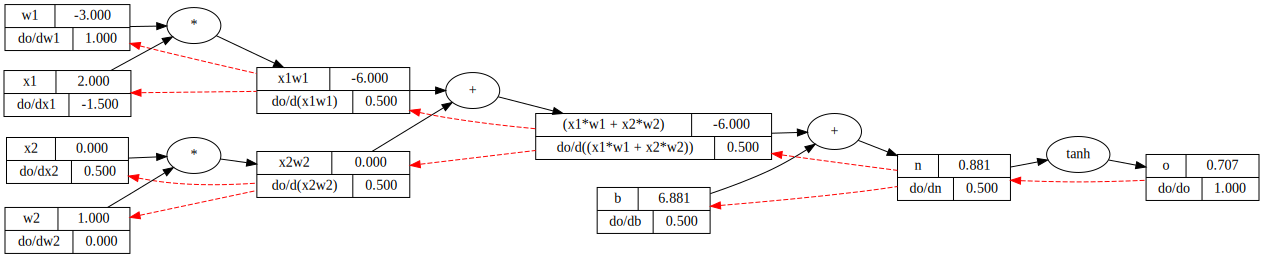

In [61]:
draw_dot(o)

In [60]:
o.backward()

In [ ]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v.prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)    
# print(topo)

# o.grad = 1.0
# for node in reversed(topo):
#   node._backward()

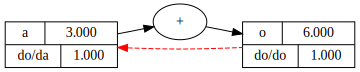

In [63]:
a = Scalar(3.0, label='a')
o = a + a; o.label = 'o'
o.backward()
draw_dot(o)

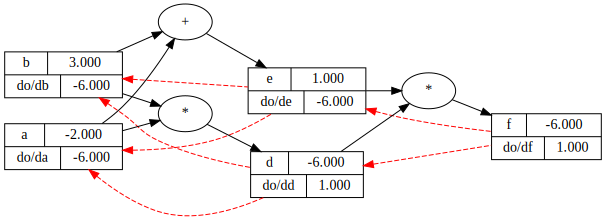

In [64]:
a = Scalar(-2.0, label='a')
b = Scalar(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
o = d*e; o.label='f'
o.backward()
draw_dot(o)